In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1013'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1013'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import adam
import matplotlib.pyplot as plt
import math
import numpy as np
env = wrap_env(gym.make('Pendulum-v0'))
env.seed(0)
np.random.seed(0)

Using TensorFlow backend.


In [0]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [0]:

def train_dqn(episode):
    global env
    loss = []
    #agent = DQN(env.action_space.n, env.observation_space.shape[0])
    agent = DQN(5, env.observation_space.shape[0])
    for e in range(episode):
        temp=[]
        state = env.reset()
        state = np.reshape(state, (1, 3))
        score = 0
        maxp = -1.2
        max_steps = 1000
        for i in range(max_steps):
            env.render()
            action = agent.act(state)
            torque = [-2+action]
            next_state, reward, done, _ = env.step(torque)
            next_state = np.reshape(next_state, (1, 3))
            if (next_state[0,0]>0.95):
                score=score+1
            reward= 25*np.exp(-1*(next_state[0,0]-1)*(next_state[0,0]-1)/0.001)-100*np.abs(10*0.5 - (10*0.5*next_state[0,0] + 0.5*0.3333*next_state[0,2] * next_state[0,2])) + 100*np.abs(10*0.5 - (10*0.5*state[0,0] + 0.5*0.3333*state[0,2] * state[0,2]))
            maxp = max(maxp, next_state[0,0])
            temp.append(next_state[0,0])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                print(maxp)
                plt.plot([i for i in range(0, 200, 1)], temp[::1])
                plt.show()
                env.close()
                show_video()
                env = wrap_env(gym.make('Pendulum-v0'))
                env.seed(episode)
                break
        loss.append(score)
    return loss

In [0]:

def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")

In [0]:
if __name__ == '__main__':
    ep = 200
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()

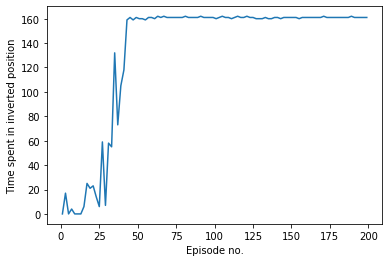

In [0]:
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.xlabel('Episode no.')
    plt.ylabel('Time spent in inverted position')
    plt.show()